In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time

# Go up 3 levels to the repo's root directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Add the repo root to sys.path
sys.path.append(repo_root)

from data_processing.helpers import normalize, sample
from models.initialization import init_single_net, neural_net, init_pinns, create_solution
from equations.simple_mass_conservation import gov_eqn
from models.optimization import adam_optimizer, lbfgs_optimizer

In [155]:
def load_fenics_results(csv, x_left=-2000, x_right=2000):
    df = pd.read_csv(f'{csv}')
    
    # Keep full df for interpolation, use filtered for main body
    df_filtered = df[abs(df['x']) < max(abs(x_left), abs(x_right))]
    df_surface = df_filtered[df_filtered['d'] <= 1e-6]

    new_rows = []

    # Interpolate at the divide (x = 0)
    for z_val in sorted(df['z'].unique()):
        df_z = df[df['z'] == z_val]
        if df_z['x'].min() <= 0 <= df_z['x'].max():
            df_z = df_z.sort_values('x')
            new_row = {
                'x': 0,
                'z': z_val,
            }
            for col in ['u', 'w', 'rho', 'p', 'mu', 'd']:
                new_row[col] = np.interp(0, df_z['x'], df_z[col])
            new_rows.append(new_row)

    df_interp = pd.DataFrame(new_rows)
    df_combined = pd.concat([df_filtered, df_interp], ignore_index=True)
    df_divide = df_combined[df_combined['x'] == 0]

    # Interpolate at flanks (using the full df!)
    flank_rows = []
    for x_target in [x_left, x_right]:
        for z_val in sorted(df['z'].unique()):
            df_z = df[df['z'] == z_val]
            if df_z['x'].min() <= x_target <= df_z['x'].max():
                df_z = df_z.sort_values('x')
                row = {
                    'x': x_target,
                    'z': z_val,
                }
                for col in ['u', 'w', 'rho', 'p', 'mu', 'd']:
                    row[col] = np.interp(x_target, df_z['x'], df_z[col])
                flank_rows.append(row)
    df_flanks = pd.DataFrame(flank_rows)

    df_bed = df_filtered[df_filtered['z'] == 0]

    return df_filtered, df_surface, df_divide, df_bed, df_flanks

In [156]:
df_full, df_surf, df_divide, df_bed, df_flanks = load_fenics_results('../../data_processing/fenics_data.csv')

In [157]:
df_flanks

,x,z,u,w,rho,p,mu,d
0,-2000,-0.000000,0.000000e+00,-5.565042e-14,917.0,5.565185e+06,9.934244e+13,6.202741e+02
1,-2000,39.275528,-2.180843e-08,-6.987363e-10,917.0,5.014563e+06,1.304153e+14,5.627744e+02
2,-2000,39.275528,-2.319899e-08,-3.698021e-10,917.0,5.121078e+06,1.304265e+14,5.721590e+02
3,-2000,560.746514,-6.341154e-07,-1.603007e-06,917.0,-5.930679e+06,4.778757e+15,2.370821e-07
4,-2000,561.178336,-6.315273e-07,-1.594399e-06,917.0,-5.961937e+06,4.797883e+15,4.439185e-03
...,...,...,...,...,...,...,...,...
73,2000,614.597488,8.510334e-08,-2.871017e-08,917.0,-8.214049e+05,6.944643e+15,1.415052e-07
74,2000,616.882717,8.115913e-08,-2.534127e-08,917.0,-7.326397e+05,7.055685e+15,-8.306176e-08
75,2000,617.122741,8.077764e-08,-2.501747e-08,917.0,-7.240508e+05,7.064862e+15,6.357158e-03
76,2000,618.802912,7.839203e-08,-2.300732e-08,917.0,-6.693731e+05,7.132999e+15,6.505368e-03


In [158]:
# generate PINN
# select a random seed
seed = 1234 #2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4) # NEED TO UPDATE 4 to relevant number
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)

In [113]:
# normalize
df_norm,df_bcs,info = normalize(df_full, df_surf, df_divide, df_bed, df_flanks)
# df_bcs contains the data for surface, divide,bed and flanks

In [114]:
pred_u = create_solution(df_bcs[0]) # need to modify as well


In [115]:
# for adam
n_samples = jnp.array([200,200]) # small number for now
dataf = sample(df_norm,n_samples,df_bcs) # nsamples is for data loss + colocation points
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])

# for L-BFGS
n_pt2 = n_samples * 2
dataf_l = sample(df_norm, n_pt2,df_bcs)
key_lbfgs = random.split(keys[2], 5)

In [116]:
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def create_loss_masscon(predf,gov_eqn,scales,lw):
    # for now do 3 lw weights: data, eqn, bc
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        net = lambda z: predf(params, z)
        
        # load the ground truth for dataloss
        x_smp = data['smp'][0]
        w_smp = data['smp'][1][:,1:2] # ground truth w
        x_div = data['div'][0]
        u_div = data['div'][1][:,0:1] # horizontal velocity at divide (should be 0)
        x_bed = data['bed'][0]
        w_bed = data['bed'][1][:,1:2] # ground truth w at bed (should be 0)
        rho_bed = data['bed'][1][:,2:3] # ground truth rho at bed (should be rho_i)
        x_surf = data['surf'][0]
        u_surf = data['surf'][1][:,0:1] # ground truth surface horizontal velocity 

        # load the position and weight of collocation points
        x_col = data['col'][0]

        # calculate the predicted variables
        w_pred = net(x_smp)[:, 1:2] # not 0:2 because we only have data in w

        # boundary constraints
        u_div_pred = net(x_div)[:,0:1]
        bed_pred = net(x_bed)
        w_bed_pred = bed_pred[:,1:2]
        rho_bed_pred = bed_pred[:,2:3]
        u_surf_pred = net(x_surf)[:,0:1]
        
        # calculate the residue of equation
        f_pred,terms = gov_eqn(net, x_col, scales)

        # calculate the mean squared root error of data
        data_err = ms_error(w_pred - w_smp)

        # calculate the mean squared root error of equation
        eqn_err = ms_error(f_pred)

        # calculate errors of boundary conditions
        div_err = ms_error(u_div_pred-u_div)
        rho_bed_err = ms_error(rho_bed-rho_bed_pred)
        w_bed_err = ms_error(w_bed-w_bed_pred)
        surf_err = ms_error(u_surf-u_surf_pred)

        # all errors should be 1d arrays
        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err)
        loss_eqn = jnp.sum(eqn_err)
        loss_bd = jnp.sum(div_err) + jnp.sum(rho_bed_err) + jnp.sum(w_bed_err) + jnp.sum(surf_err)

        loss_ref = loss_fun.lref
        # calculate total loss

        # lw should have 3 weights
        loss = (lw[0]*loss_data + lw[1]*loss_eqn + lw[2]*loss_bd ) / loss_ref
        
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err, div_err, rho_bed_err, w_bed_err,surf_err])
        return loss, loss_info

    loss_fun.lref = 1.0
    return loss_fun

In [117]:
# create the loss function
NN_loss = create_loss_masscon(pred_u, gov_eqn, info, [1,1,1])
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

In [118]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 3.6065e-02 | Loss_d: 3.0241e-02 | Loss_e: 4.5816e-02 | Loss_b: 3.6512e-01
Step: 200 | Loss: 1.5765e-02 | Loss_d: 3.5364e-02 | Loss_e: 2.7134e-02 | Loss_b: 1.3035e-01
Step: 300 | Loss: 5.7604e-03 | Loss_d: 2.1797e-02 | Loss_e: 6.6769e-03 | Loss_b: 4.1992e-02
Step: 400 | Loss: 2.5110e-03 | Loss_d: 9.5568e-03 | Loss_e: 2.3893e-03 | Loss_b: 1.8771e-02
Step: 500 | Loss: 1.5071e-03 | Loss_d: 5.5047e-03 | Loss_e: 1.8144e-03 | Loss_b: 1.1117e-02
Step: 600 | Loss: 9.5681e-04 | Loss_d: 3.6281e-03 | Loss_e: 1.2081e-03 | Loss_b: 6.8682e-03
Step: 700 | Loss: 7.6931e-04 | Loss_d: 4.4325e-03 | Loss_e: 7.0730e-04 | Loss_b: 4.2710e-03
Step: 800 | Loss: 5.8782e-04 | Loss_d: 3.3382e-03 | Loss_e: 7.8361e-04 | Loss_b: 3.0688e-03
Step: 900 | Loss: 3.6197e-04 | Loss_d: 1.9210e-03 | Loss_e: 5.2600e-04 | Loss_b: 1.9808e-03
Step: 1000 | Loss: 3.6483e-04 | Loss_d: 2.7659e-03 | Loss_e: 5.1496e-04 | Loss_b: 1.1821e-03
Step: 1100 | Loss: 2.1555e-04 | Loss_d: 1.3494e-03 | Loss_e: 4.2068e-04 | Loss_

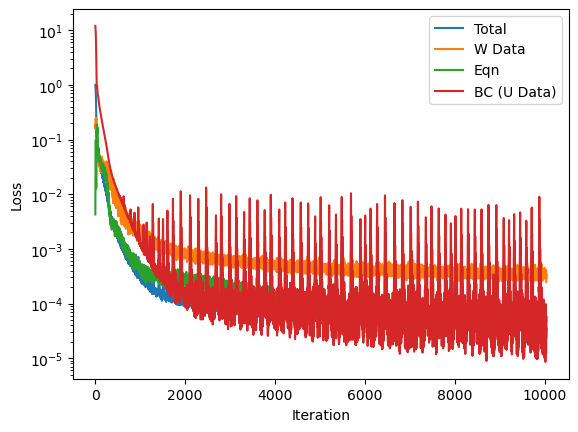

In [119]:
def plot_loss(loss):
  np_loss = np.array(loss)
  plt.semilogy(np_loss[:,0],label='Total')
  plt.semilogy(np_loss[:,1],label='W Data')
  plt.semilogy(np_loss[:,2],label='Eqn')
  plt.semilogy(np_loss[:,3],label='BC (U Data)')
  plt.legend()
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
plot_loss(loss1)

In [120]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 3.7299e-05 | Loss_d: 3.7847e-04 Loss_e: 6.5632e-05 | Loss_b: 1.2167e-05
Step: NaN | Loss: 1.0438e-04 | Loss_d: 4.2166e-04 Loss_e: 1.1022e-04 | Loss_b: 7.4496e-04
Step: NaN | Loss: 3.5988e-05 | Loss_d: 3.4612e-04 Loss_e: 6.2227e-05 | Loss_b: 3.1882e-05
Step: NaN | Loss: 3.6405e-05 | Loss_d: 3.4133e-04 Loss_e: 6.1810e-05 | Loss_b: 4.2191e-05
Step: NaN | Loss: 3.5937e-05 | Loss_d: 3.4490e-04 Loss_e: 6.2113e-05 | Loss_b: 3.2586e-05
Step: NaN | Loss: 3.5922e-05 | Loss_d: 3.4479e-04 Loss_e: 6.2055e-05 | Loss_b: 3.2584e-05
Step: NaN | Loss: 3.5876e-05 | Loss_d: 3.4435e-04 Loss_e: 6.1839e-05 | Loss_b: 3.2679e-05
Step: NaN | Loss: 3.5927e-05 | Loss_d: 3.4272e-04 Loss_e: 6.1127e-05 | Loss_b: 3.5637e-05
Step: NaN | Loss: 3.5841e-05 | Loss_d: 3.4360e-04 Loss_e: 6.1488e-05 | Loss_b: 3.3344e-05
Step: NaN | Loss: 3.5758e-05 | Loss_d: 3.4341e-04 Loss_e: 6.0861e-05 | Loss_b: 3.3144e-05
Step: NaN | Loss: 3.6164e-05 | Loss_d: 3.4517e-04 Loss_e: 6.1111e-05 | Loss_b: 3.6103e-05
Step: NaN 

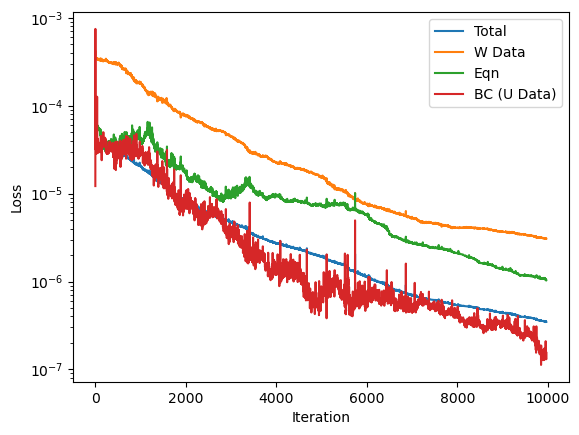

In [121]:
plot_loss(loss2)

In [122]:
# now lets make a prediction - this cell likely does not need to be changed
from equations.gradients import *
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn = lambda x: gov_eqn(f_u, x, info)

x_pred = df_norm[['x','z']].values
uw_rho_pmu = f_u(x_pred)
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list = tree_map(lambda x: f_eqn(x_psp[x]), idxsp)
eqn_list = tree_map(lambda x: eqnterm_list[x][0], idxsp)
term_list = tree_map(lambda x: eqnterm_list[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn = jnp.vstack(eqn_list)
term = jnp.vstack(term_list)
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_full[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
    results[f'{key}x_p'] = duw_rho_pmu[:,2*i:2*i+1] * info[f'{key}_range']/info['x_range']
    results[f'{key}z_p'] = duw_rho_pmu[:,2*i+1:2*i+2] * info[f'{key}_range']/info['z_range']
    
results['x'] = df_full['x'].values
results['z'] = df_full['z'].values

In [123]:
# predicting equation terms is unique to each model
term0 = info['rho_range']*info['w_range']/info['z_range']
results['e0']=eqn[:, 0:1] * term0
results['e01']=term[:, 0:1] * term0
results['e02']=term[:, 1:2] * term0

Text(0, 0.5, 'Inversion results')

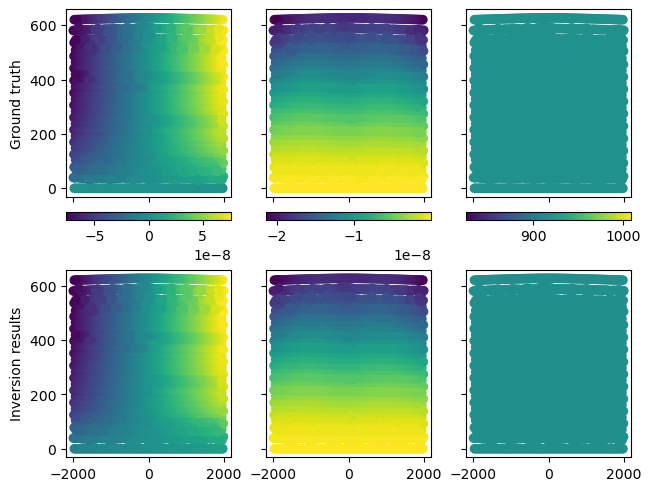

In [124]:
fig, axs = plt.subplots(nrows=2,ncols=3,layout='constrained',sharex=True,sharey=True)
for i,key in enumerate(['u','w','rho']):
    c = axs[0,i].scatter(results['x'],results['z'],c=results[f'{key}_g'])
    fig.colorbar(c, ax=axs[0, i], location='bottom')
    new_c = axs[1, i].scatter(results['x'], results['z'], 
                          c=results[f'{key}_p'], 
                          cmap=c.cmap, norm=c.norm)
axs[0][0].set_ylabel('Ground truth')
axs[1][0].set_ylabel('Inversion results')

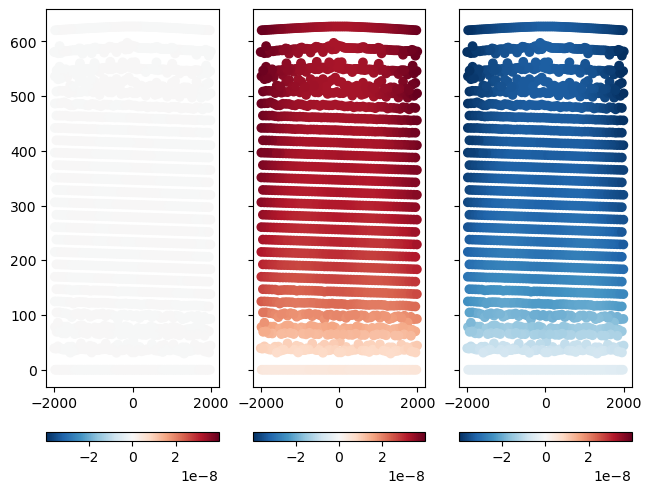

In [125]:
# check equation physics
fig, axs = plt.subplots(ncols=3,layout='constrained',sharex=True,sharey=True)
vmax = np.max(np.abs([results['e0'],results['e01'],results['e02']]))
for i, key in enumerate(['e0','e01','e02']):
    c = axs[i].scatter(results['x'],results['z'],c=results[key],vmin=-vmax,vmax=vmax,cmap='RdBu_r')
    fig.colorbar(c, ax=axs[i], location='bottom')

# Now, we test just momentum

In [159]:
from equations.momentum_conservation import gov_eqn as gov_eqn_momentum


In [160]:
# generate PINN
# select a random seed
seed = 1234 #2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4) # NEED TO UPDATE 4 to relevant number
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)

In [161]:
# normalize
df_norm,df_bcs,info = normalize(df_full, df_surf, df_divide, df_bed, df_flanks)
# df_bcs contains the data for surface, divide,bed and flanks

In [162]:
pred_u = create_solution(df_bcs[0]) # need to modify as well


In [163]:
# for adam
n_samples = jnp.array([200,200]) # small number for now
dataf = sample(df_norm,n_samples,df_bcs) # nsamples is for data loss + colocation points
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])

# for L-BFGS
n_pt2 = n_samples * 2
dataf_l = sample(df_norm, n_pt2,df_bcs)
key_lbfgs = random.split(keys[2], 5)

In [184]:
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def create_loss_momentum(predf,gov_eqn,scales,lw):
    # for now do 3 lw weights: data, eqn, bc
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        net = lambda z: predf(params, z)
        
        # load the ground truth for dataloss
        x_smp = data['smp'][0]
        U_smp = data['smp'][1][:,0:5] # ground truth u,w,rho 
        # assuming only surface ice pressure is known
        x_surf = data['surf'][0]
        p_surf = data['surf'][1][:,3:4] # ground truth surface ice pressure
        
        # assuming known viscosities at flanks
        x_flanks = data['flanks'][0]
        mu_flanks = data['flanks'][1][:,4:5] # doing viscosities at flank

        # load the position and weight of collocation points
        x_col = data['col'][0]

        # calculate the predicted variables
        U_pred = net(x_smp)[:, 0:5] # predicting u, w, rho

        # boundary constraints
        p_surf_pred = net(x_surf)[:,3:4]
        mu_flanks_pred = net(x_flanks)[:,4:5]
        
        # calculate the residue of equation
        f_pred,terms = gov_eqn(net, x_col, scales)

        # calculate the mean squared root error of data
        data_err = ms_error(U_pred - U_smp)

        # calculate the mean squared root error of equation
        eqn_err = ms_error(f_pred)

        # calculate errors of boundary conditions
        surf_err = ms_error(p_surf-p_surf_pred)
        flanks_err = ms_error(mu_flanks-mu_flanks_pred)

        # all errors should be 1d arrays
        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err)
        loss_eqn = jnp.sum(eqn_err)
        loss_bd = jnp.sum(flanks_err) + jnp.sum(surf_err)

        loss_ref = loss_fun.lref
        # calculate total loss

        # lw should have 3 weights
        loss = (lw[0]*loss_data + lw[1]*loss_eqn + lw[2]*loss_bd ) / loss_ref
        
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err, flanks_err,surf_err])
        return loss, loss_info

    loss_fun.lref = 1.0
    return loss_fun

In [185]:
# create the loss function
NN_loss = create_loss_momentum(pred_u, gov_eqn, info, [1,1,1])
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

In [186]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 2.4807e-03 | Loss_d: 1.8952e-03 | Loss_e: 1.9606e-05 | Loss_b: 6.9395e-04
Step: 200 | Loss: 1.1539e-03 | Loss_d: 9.7824e-04 | Loss_e: 1.8089e-05 | Loss_b: 2.1715e-04
Step: 300 | Loss: 8.0186e-04 | Loss_d: 6.9235e-04 | Loss_e: 1.4679e-05 | Loss_b: 1.3622e-04
Step: 400 | Loss: 5.6913e-04 | Loss_d: 5.1628e-04 | Loss_e: 1.2952e-05 | Loss_b: 6.9265e-05
Step: 500 | Loss: 3.9756e-04 | Loss_d: 3.5460e-04 | Loss_e: 1.4237e-05 | Loss_b: 4.9241e-05
Step: 600 | Loss: 3.8910e-04 | Loss_d: 3.1650e-04 | Loss_e: 1.1835e-05 | Loss_b: 8.0840e-05
Step: 700 | Loss: 2.7016e-04 | Loss_d: 2.3356e-04 | Loss_e: 1.6292e-05 | Loss_b: 3.4249e-05
Step: 800 | Loss: 3.3802e-04 | Loss_d: 3.0757e-04 | Loss_e: 1.5495e-05 | Loss_b: 3.2407e-05
Step: 900 | Loss: 3.4297e-04 | Loss_d: 3.2385e-04 | Loss_e: 1.2400e-05 | Loss_b: 2.4418e-05
Step: 1000 | Loss: 5.9933e-04 | Loss_d: 3.2830e-04 | Loss_e: 1.7838e-05 | Loss_b: 2.8412e-04
Step: 1100 | Loss: 6.1886e-04 | Loss_d: 5.3864e-04 | Loss_e: 2.1889e-05 | Loss_

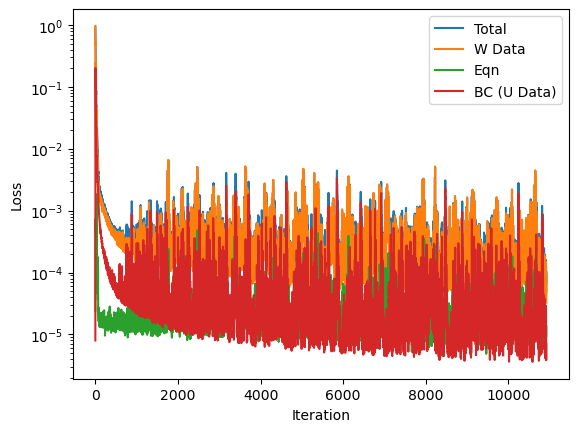

In [187]:
def plot_loss(loss):
  np_loss = np.array(loss)
  plt.semilogy(np_loss[:,0],label='Total')
  plt.semilogy(np_loss[:,1],label='W Data')
  plt.semilogy(np_loss[:,2],label='Eqn')
  plt.semilogy(np_loss[:,3],label='BC (U Data)')
  plt.legend()
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
plot_loss(loss1)

In [188]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 5.7868e-05 | Loss_d: 4.1678e-05 Loss_e: 1.0135e-05 | Loss_b: 9.0407e-06
Step: NaN | Loss: 3.9010e-01 | Loss_d: 2.6997e-01 Loss_e: 9.0258e-03 | Loss_b: 1.3124e-01
Step: NaN | Loss: 4.3187e-05 | Loss_d: 3.1934e-05 Loss_e: 8.2921e-06 | Loss_b: 5.1898e-06
Step: NaN | Loss: 3.9248e-05 | Loss_d: 2.9658e-05 Loss_e: 7.7685e-06 | Loss_b: 3.8477e-06
Step: NaN | Loss: 5.1707e-05 | Loss_d: 3.9982e-05 Loss_e: 6.8858e-06 | Loss_b: 7.5080e-06
Step: NaN | Loss: 3.8115e-05 | Loss_d: 2.9268e-05 Loss_e: 7.4024e-06 | Loss_b: 3.4111e-06
Step: NaN | Loss: 3.7094e-05 | Loss_d: 2.8563e-05 Loss_e: 7.0901e-06 | Loss_b: 3.3554e-06
Step: NaN | Loss: 3.9587e-05 | Loss_d: 2.9895e-05 Loss_e: 6.9181e-06 | Loss_b: 4.8170e-06
Step: NaN | Loss: 3.6731e-05 | Loss_d: 2.8271e-05 Loss_e: 6.8779e-06 | Loss_b: 3.4787e-06
Step: NaN | Loss: 3.5841e-05 | Loss_d: 2.7528e-05 Loss_e: 6.7174e-06 | Loss_b: 3.4446e-06
Step: NaN | Loss: 3.6090e-05 | Loss_d: 2.7872e-05 Loss_e: 6.5271e-06 | Loss_b: 3.5531e-06
Step: NaN 

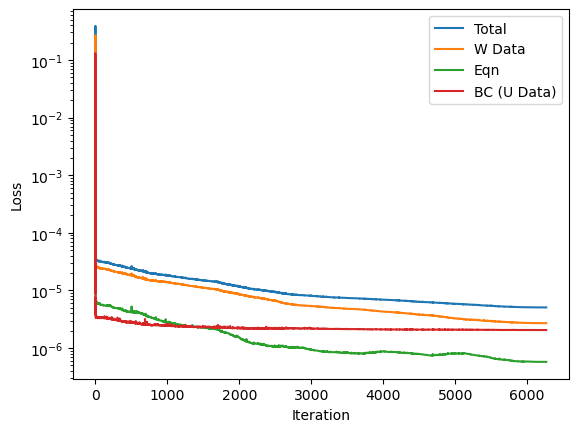

In [189]:
plot_loss(loss2)

In [190]:
# now lets make a prediction - this cell likely does not need to be changed
from equations.gradients import *
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn = lambda x: gov_eqn_momentum(f_u, x, info)

x_pred = df_norm[['x','z']].values
uw_rho_pmu = f_u(x_pred)
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list = tree_map(lambda x: f_eqn(x_psp[x]), idxsp)
eqn_list = tree_map(lambda x: eqnterm_list[x][0], idxsp)
term_list = tree_map(lambda x: eqnterm_list[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn = jnp.vstack(eqn_list)
term = jnp.vstack(term_list)
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_full[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
    results[f'{key}x_p'] = duw_rho_pmu[:,2*i:2*i+1] * info[f'{key}_range']/info['x_range']
    results[f'{key}z_p'] = duw_rho_pmu[:,2*i+1:2*i+2] * info[f'{key}_range']/info['z_range']
    
results['x'] = df_full['x'].values
results['z'] = df_full['z'].values


In [191]:
# predicting equation terms is unique to each model
term0 = info['rho_range']*9.81*info['z_range']/info['x_range']
results['e1']=eqn[:, 0:1] * term0
results['e11']=term[:, 0:1] * term0
results['e12']=term[:, 1:2] * term0
results['e13']=term[:, 2:3] * term0

term1 = info['rho_range']*9.81
results['e2']=eqn[:, 1:2] * term1
results['e21']=term[:, 3:4] * term1
results['e22']=term[:, 4:5] * term1
results['e23']=term[:, 5:6] * term1

Text(0, 0.5, 'Inversion results')

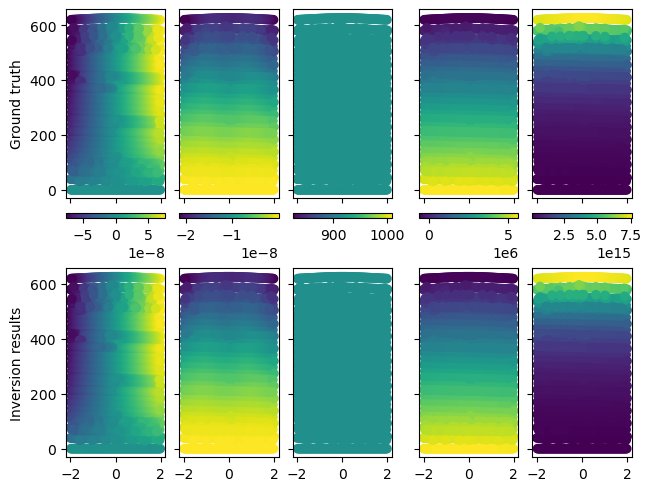

In [192]:
fig, axs = plt.subplots(nrows=2,ncols=5,layout='constrained',sharex=True,sharey=True)
for i,key in enumerate(['u','w','rho','p','mu']):
    c = axs[0,i].scatter(results['x']/1000,results['z'],c=results[f'{key}_g'])
    fig.colorbar(c, ax=axs[0, i], location='bottom')
    new_c = axs[1, i].scatter(results['x']/1000, results['z'], 
                          c=results[f'{key}_p'], 
                          cmap=c.cmap, norm=c.norm)
axs[0][0].set_ylabel('Ground truth')
axs[1][0].set_ylabel('Inversion results')

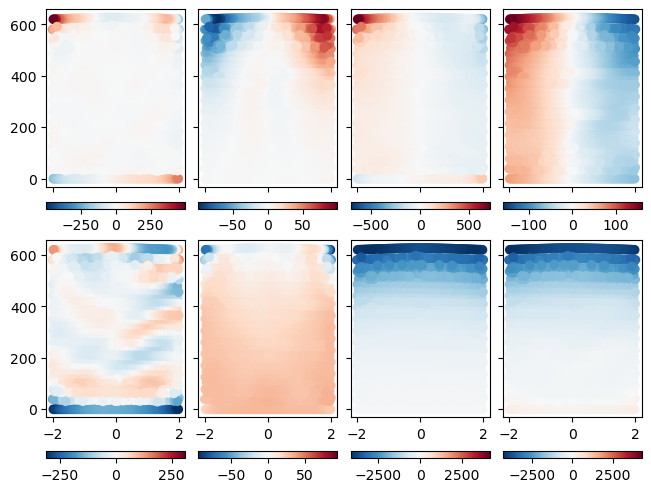

In [202]:
# check equation physics
from matplotlib import colors
fig, axs = plt.subplots(ncols=4,nrows=2,layout='constrained',sharex=True,sharey=True)
vmax = np.max(np.abs([results['e1'],results['e11'],results['e12'],results['e13'],
                     results['e2'],results['e21'],results['e22'],results['e23']]))

c=axs[0,0].scatter(results['x']/1000,results['z'],c=results['e1'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
fig.colorbar(c, ax=axs[0,0], location='bottom')
c = axs[1,0].scatter(results['x']/1000,results['z'],c=results['e2'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
fig.colorbar(c, ax=axs[1,0], location='bottom')

for i in range(3):
    c = axs[0,i+1].scatter(results['x']/1000,results['z'],c=results[f'e1{i+1}'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
    fig.colorbar(c, ax=axs[0,i+1], location='bottom')
    c = axs[1,i+1].scatter(results['x']/1000,results['z'],c=results[f'e2{i+1}'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
    fig.colorbar(c, ax=axs[1,i+1], location='bottom')
